In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
import BasicTools as BT
import WaveTools as WT
import PlotTools as PT
import FFTTools as FFTT
import OperatorTools as OT
import GridTransferTools as GTT
import TestTools as TT
import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh = 16
c = 1.
CFL = 0.5
nt = 2
RK = 2
deriv = 'U'

In [3]:
if (RK == 1):
    TimeIntegratorFunc = ST.ForwardEuler
else:
    if (RK == 2):
        TimeIntegratorFunc = ST.MidpointMeth
    else:
        TimeIntegratorFunc = ST.RK4

if (deriv == 'U'):
    DiffMatFunc = OT.Upwind1D
    DiffFunc = ST.Upwind
else:
    DiffMatFunc = OT.CenterDiff1D
    DiffFunc = ST.CenterDiff

In [4]:
omega = BT.Grid(nh)
degFreed = omega.degFreed
t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
derivMat = DiffMatFunc(omega)
spatOp = -c * derivMat
timePropOp = LA2.expm(t * spatOp)
waves = WT.MakeWaves(omega)

In [5]:
print('derivMat =\n', derivMat, '\n')
print('spatOp =\n', spatOp, '\n')
print('timePropOp =\n', timePropOp, '\n')

derivMat =
 [[ 16.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. -16.]
 [-16.  16.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -16.  16.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -16.  16.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -16.  16.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -16.  16.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -16.  16.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -16.  16.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. -16.  16.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -16.  16.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. -16.  16.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. -16.  16.   0.   0.   0

In [6]:
# sqStart = int(nh / 8)
# sqEnd = int((2 * nh) / 8)
# print(sqStart, sqEnd)
# waveform = np.zeros(degFreed, float)
# waveform[sqStart:sqEnd] = 1
FCoefs = np.ones(degFreed, float) # FFTT.FourierCoefs(omega, waves, waveform)
# FCoefs[1::2] = 0
print(FCoefs)
waveform = waves @ FCoefs
solverCoefs = TimeIntegratorFunc(omega, waves, waveform, nt, c, CFL, DiffFunc)
exTimeForm = timePropOp @ waveform
exTimeCoefs = FFTT.FourierCoefs(omega, waves, exTimeForm)
propFCoefs = FFTT.PropogateFCoefs(omega, FCoefs, c, t)
labels = [r'$u_{0} (x)$', r'Solver $u_{0} (x - c t)$', r'Exact Time $u_{0} (x - c t)$', r'Exact $u_{0} (x - c t)$']
allCoefs = PT.Load(FCoefs, solverCoefs, exTimeCoefs, propFCoefs)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
shift coefs before: (16,)
shift coefs after: (16,)


Are you *sure* your labels are ordered correctly?


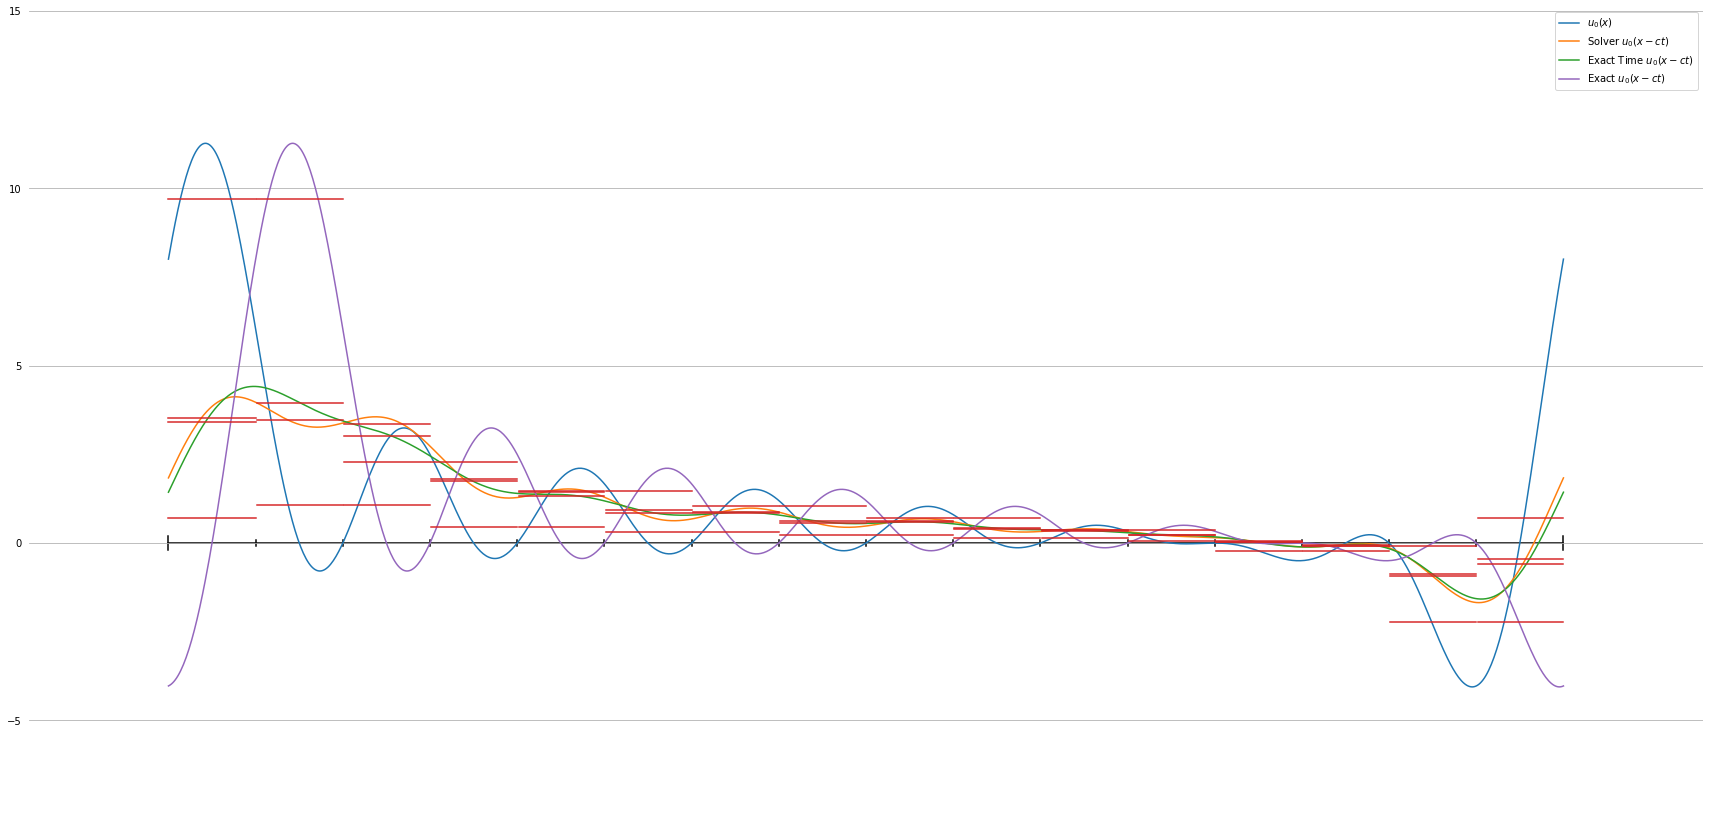

In [7]:
PT.PlotMixedWave(omega, waves, allCoefs, rescale = 6, labels = labels, yGrid = True)


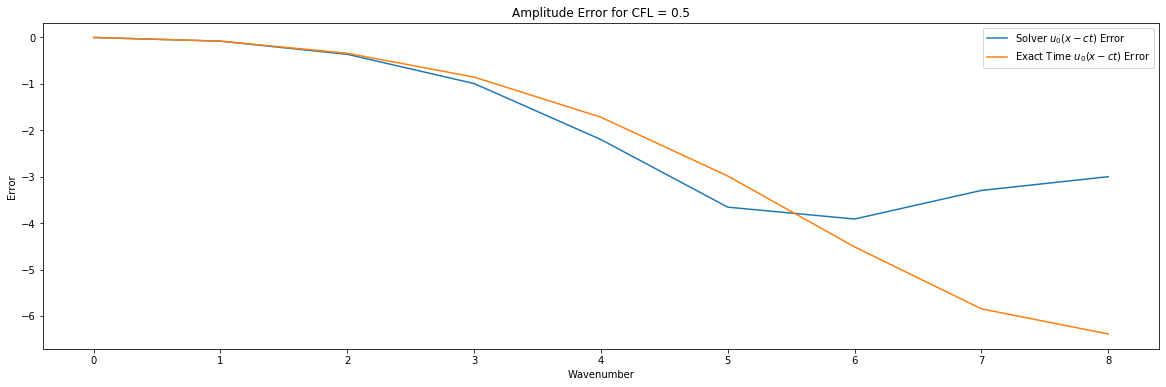

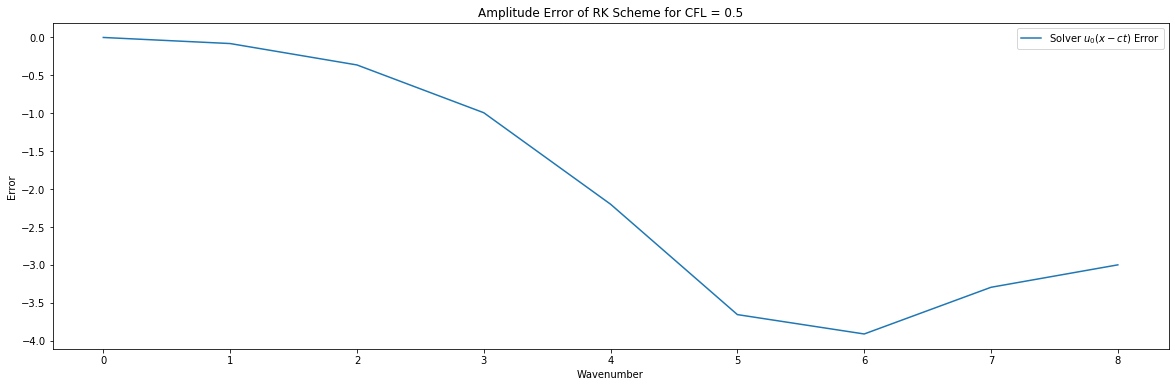

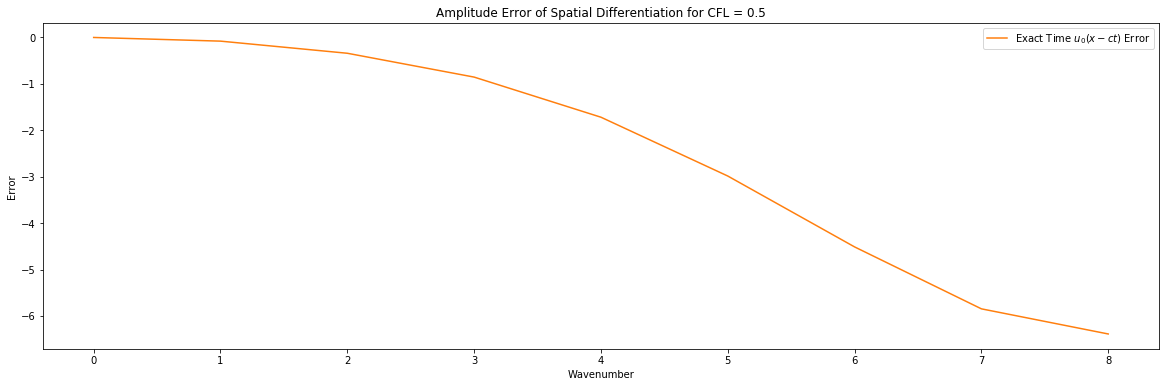

In [8]:
ampKs, solverError = TT.AmpError(omega, solverCoefs, propFCoefs)
ampKs, exTimeError = TT.AmpError(omega, exTimeCoefs, propFCoefs)
# ks, error = TT.CalcError(omega, propFCoefs, EulerCoefs, errorType = 'relative')
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ampKs, solverError, label = labels[1] + ' Error', color = PT.ColorDefault(0))
plt.plot(ampKs, exTimeError, label = labels[2] + ' Error', color = PT.ColorDefault(1))
plt.title('Amplitude Error for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ampKs, solverError, label = labels[1] + ' Error', color = PT.ColorDefault(0))
plt.title('Amplitude Error of RK Scheme for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ampKs, exTimeError, label = labels[2] + ' Error', color = PT.ColorDefault(1))
plt.title('Amplitude Error of Spatial Differentiation for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
plt.show()